In [ ]:
!python -V

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.8.2
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.2
keras.api._v2.keras 2.8.0


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip list|grep kaggle

kaggle                        1.5.12


In [4]:
# 去kaggle那边拿数据，需要有key
import json
token = {"username":"yf9761","key":"49473b3a8574a87b8e62f8b01f265d4b"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)  # json.dump类似于write

In [5]:
!cat /content/kaggle.json

{"username": "yf9761", "key": "49473b3a8574a87b8e62f8b01f265d4b"}

In [6]:
!ls -l ~/.kaggle

ls: cannot access '/root/.kaggle': No such file or directory


In [7]:
# 顺序是固定的
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [8]:
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [9]:
# 从kaggle下载数据
!kaggle datasets download -d slothkong/10-monkey-species

 95% 521M/547M [00:11<00:00, 31.1MB/s]
100% 547M/547M [00:11<00:00, 50.9MB/s]


In [10]:
!ls datasets/slothkong/10-monkey-species

10-monkey-species.zip


In [ ]:
!unzip -o -d /content /content/datasets/slothkong/10-monkey-species/10-monkey-species.zip

In [12]:
!ls /content

datasets  kaggle.json  monkey_labels.txt  sample_data  training  validation


# 新段落

In [13]:
train_dir = "./training/training"
valid_dir = "./validation/validation"
label_file = "./monkey_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))

True
True
True
['n5', 'n4', 'n0', 'n1', 'n6', 'n8', 'n2', 'n3', 'n7', 'n9']
['n5', 'n4', 'n0', 'n1', 'n6', 'n8', 'n2', 'n3', 'n7', 'n9']


In [14]:
!nvidia-smi

Tue Jul 26 13:47:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
!pwd

/content


In [19]:
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [22]:
height = 128
width = 128
channels = 3
batch_size = 64
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,  # 图片中的每个像素点都乘以1/255
    rotation_range = 40,  # 把图形随机旋转一个角度，在0-40度之间
    width_shift_range = 0.2,  # 位移，0-20%之间选择做偏移
    height_shift_range = 0.2,  # 垂直方向位移，如果是0-1之间的数，就是比例，大于1就是像素
    shear_range = 0.2,  # 剪切强度（逆时针剪切角，以度为单位）
    zoom_range = 0.2,  # 缩放强度
    horizontal_flip = True,  # 水平随机翻转
    fill_mode = 'nearest',  # 图形放大后，有些地方需要填充，可以是“常数”，“最近”，“反射”或“环绕”之一。默认值为“最近”。输入边界之外的点将根据给定模式进行填充
)
# 读取图片
train_generator = train_datagen.flow_from_directory(train_dir,
                          target_size = (height, width),  # 生成图片多大
                          batch_size = batch_size,  # 生成的图片以多少张为一组
                          seed = 7,
                          shuffle = True,               
                          class_mode = "categorical",  # one-hot编码后的一种模式
)
# 对验证集必须做一个值的缩放，其他的不需要做
valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                           target_size = (height, width),
                           batch_size = batch_size,
                           seed = 7,
                           shuffle = False,
                           class_mode = "categorical")
train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [23]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(64, 128, 128, 3) (64, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.

In [24]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                        activation='relu', input_shape=[width, height, channels]),
    # 3*3*3*32+32
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                        activation='relu'),
    # 3*3*32*32+32
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                        activation='relu'),
    # 3*3*32*64+64
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss="categorical_crossentropy",
              optimizer="adam", 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

In [25]:
len(model.layers)

12

In [26]:
epochs = 50
history = model.fit(train_generator,
          steps_per_epoch = train_num // batch_size,
          epochs = epochs,
          validation_data = valid_generator,
          validation_steps = valid_num // batch_size)

Epoch 1/50
17/17 [==============================] - 46s 2s/step - loss: 2.3449 - accuracy: 0.1025 - val_loss: 2.2989 - val_accuracy: 0.1094
Epoch 2/50
17/17 [==============================] - 33s 2s/step - loss: 2.2872 - accuracy: 0.1209 - val_loss: 2.2666 - val_accuracy: 0.1211
Epoch 3/50
17/17 [==============================] - 33s 2s/step - loss: 2.2171 - accuracy: 0.1818 - val_loss: 2.2167 - val_accuracy: 0.2578
Epoch 4/50
17/17 [==============================] - 35s 2s/step - loss: 2.1065 - accuracy: 0.2224 - val_loss: 1.9852 - val_accuracy: 0.2422
Epoch 5/50
17/17 [==============================] - 33s 2s/step - loss: 1.9892 - accuracy: 0.2466 - val_loss: 1.9369 - val_accuracy: 0.2617
Epoch 6/50
17/17 [==============================] - 33s 2s/step - loss: 1.9851 - accuracy: 0.2689 - val_loss: 1.9706 - val_accuracy: 0.3164
Epoch 7/50
17/17 [==============================] - 33s 2s/step - loss: 1.9576 - accuracy: 0.2843 - val_loss: 1.8433 - val_accuracy: 0.3711
Epoch 8/50
17/17 [==

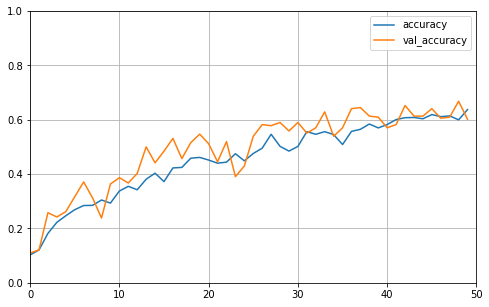

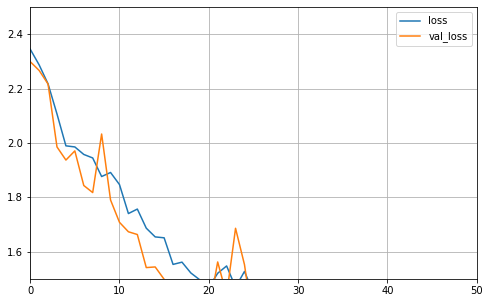

In [27]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
# 因为accuracy的值和loss值的范围很不一样，因此打印两条曲线
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 1.5, 2.5)